In [1]:
import sys
import os
from tqdm import tqdm

import glob
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

from datetime import datetime

In [2]:
print("PyTorch version: ", torch.__version__)
print("GPU Detected:" ,torch.cuda.is_available())
print("GPU Device Name:", torch.cuda.get_device_name(0))

#defining a shortcut function for later:
# import os
# using_GPU = os.path.exists('/opt/bin/nvidia-smi')

using_GPU = torch.cuda.is_available()


PyTorch version:  1.9.0+cu102
GPU Detected: True
GPU Device Name: NVIDIA GeForce MX150


In [3]:
dataFolderPath = os.path.join("data2_1")

In [4]:
trainingPercentage = 0.7
testPercentage = 0.3

In [5]:
folders = ["data2_1", "data2_2", "data2_3"]
csvLists = [glob.glob(f"{folder}/*.csv") for folder in folders]

In [6]:
# print(csvLists)

In [6]:
overallTrain = []
overallTest = []
for csvList in csvLists:  
  train, test = train_test_split(csvList,
                                test_size=testPercentage,
                                train_size=trainingPercentage)
  overallTrain.extend(train)
  overallTest.extend(test)

## Define and fine tune the pre-process function
Our dataset contains many columns we don't need

In [7]:
def preProcessDataFrame(df: pd.DataFrame) -> pd.DataFrame:
  """
  Takes in a dataframe and returns another dataframe that contains only the data we want.
  Might wanna normalise the data as well
  Maybe fill the nulls with zeros or other appropriate values.
  """
  df_cp = df.copy()
  
#   df_cp.dropna(axis=0,
#                how='any', 
#                subset=["username", "tweet id"], 
#                inplace=True)
  
  df_cp = df_cp[["#followers",
                "#friends",
                "#retweets",
                "#favorites",
                "weekend",
                "entity_count",
                "hashtag_count",
                "mention_count",
                "url_count",
                "tlen",
                "ratio_fav_#followers",
                "time_importance",
                "sentiment_ppn",
                "sine_hour",
                "cosine_hour",
                "sine_day",
                "cosine_day",
                "sine_day_of_week",
                "cosine_day_of_week"
                ]]
  return df_cp


# sampleDf = pd.read_csv(overallTrain[0])
sampleDf = pd.read_csv(f"{dataFolderPath}/covid_data_1.csv")
# print(sampleDf.head())
print(sampleDf.info())
# [print(x) for x in sampleDf.columns] # show list of columns in sampleDf
print("\n====[AFTER PRE-PROCESSING]====\n")
# print(preProcessDataFrame(sampleDf.head()))
pp = preProcessDataFrame(sampleDf)
print(pp.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 41 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            10000 non-null  int64  
 1   tweet_id              10000 non-null  int64  
 2   username              10000 non-null  object 
 3   timestamp             10000 non-null  object 
 4   #followers            10000 non-null  float64
 5   #friends              10000 non-null  int64  
 6   #retweets             10000 non-null  int64  
 7   #favorites            10000 non-null  int64  
 8   entities              10000 non-null  object 
 9   sentiment             10000 non-null  object 
 10  mentions              9984 non-null   object 
 11  hashtags              9998 non-null   object 
 12  urls                  10000 non-null  object 
 13  timeseg               10000 non-null  int64  
 14  date                  10000 non-null  object 
 15  weekend             

In [8]:
class TwitterDataset(Dataset):
  def __init__(self, filenames, preProcessFunc = None):
    # `filenames` is a list of strings the contains all file names.
    # `batch_size` is the determines the number of files that we want to read in a chunk.
        self.filenames = filenames
        self.preProcess = preProcessFunc
  def __len__(self):
        return len(self.filenames)
  def __getitem__(self, idx): #idx means index of the chunk.
    # In this method, we do all the preprocessing.
    # First read data from files in a chunk. Preprocess it. Extract labels. Then return data and labels.
        csvFile = self.filenames[idx]
        df = pd.read_csv(csvFile)
        if self.preProcess:
          df = self.preProcess(df)

        x_arr = torch.Tensor(df.drop(columns=['#retweets']).to_numpy().astype(float))
        y = torch.Tensor(df["#retweets"].to_numpy().astype(float))
        X = torch.squeeze( x_arr )
        if idx == self.__len__():  
          raise IndexError
        return X, y
  def sample_df(self, idx = 0):
    return self[idx]

In [9]:
train_loader = DataLoader(dataset = TwitterDataset(overallTrain, preProcessDataFrame),
                            batch_size = 1,
                            shuffle = True)
                            
test_loader = DataLoader(dataset = TwitterDataset(overallTest, preProcessDataFrame),
                            batch_size = 1,
                            shuffle = True)

# Build the network
Make sure this network takes in whatever input you give it and outputs a number. Alternative, if this is an immediate model, like the zero/more than zero retweets classifier, than train it and save the parameters externally. Then train the regressor in another copy of this script.

In [10]:
class myNeuralNetwork(nn.Module): # Please change the name to your own network
  def __init__(self, input_size):
    super(myNeuralNetwork, self).__init__()

    self.fc1 = nn.Linear(input_size, 2048)
    self.fc2 = nn.Linear(2048, 512)
    self.fc3 = nn.Linear(512, 128)
    self.fc4 = nn.Linear(128, 1)
    self.dropout = nn.Dropout(0.3)
    self.nonlinearity = nn.ReLU()
    self.batchnorm1 = nn.BatchNorm1d(2048)
    self.batchnorm2 = nn.BatchNorm1d(512)
    self.batchnorm3 = nn.BatchNorm1d(128)

    pass

  def forward(self, x):

    x = self.dropout(F.relu(self.batchnorm1(self.fc1(x))))
    x = self.dropout(F.relu(self.batchnorm2(self.fc2(x))))
    x = self.dropout(F.relu(self.batchnorm3(self.fc3(x))))
    x = F.relu(self.fc4(x))

    return x

class myNeuralNetwork2(nn.Module): # Please change the name to your own network
  def __init__(self, input_size):
    super(myNeuralNetwork2, self).__init__()

    self.fc1 = nn.Linear(input_size, 256)
    self.fc2 = nn.Linear(256, 64)
    self.fc3 = nn.Linear(64, 64)
    self.fc4 = nn.Linear(64, 1)
    self.dropout = nn.Dropout(0.3)
    self.nonlinearity = nn.ReLU()
    self.batchnorm1 = nn.BatchNorm1d(256)
    self.batchnorm2 = nn.BatchNorm1d(64)
    self.batchnorm3 = nn.BatchNorm1d(64)

    pass

  def forward(self, x):

    x = self.dropout(F.relu(self.batchnorm1(self.fc1(x))))
    x = self.dropout(F.relu(self.batchnorm2(self.fc2(x))))
    x = self.dropout(F.relu(self.batchnorm3(self.fc3(x))))
    x = F.relu(self.fc4(x))

    return x
  

In [11]:
now = datetime.now()

d4 = now.strftime("%Y%m%d_%H%M%S")

# PATH = "model/model_{0}.pt".format(d4) #change this name to the name of your network

# print(PATH)

# PATH1 = "model_{0}.pt".format(d4)

  0%|          | 0/40 [00:00<?, ?it/s]

Model on GPU?:
True
Epoch: 0, Loss: 3.178997278213501, 
MSELoss: 3.3783068656921387
Average MSELoss: 3.389710478743246
model/model_20210809_032813_0.pt


  5%|▌         | 2/40 [18:50<5:59:00, 566.86s/it]

Epoch: 1, Loss: 2.9529240131378174, 
MSELoss: 2.973259687423706
Average MSELoss: 2.9803900947255535


  8%|▊         | 3/40 [28:31<5:53:36, 573.43s/it]

Epoch: 2, Loss: 2.560088634490967, 
MSELoss: 2.529940128326416
Average MSELoss: 2.5580182465639982


 10%|█         | 4/40 [38:15<5:46:33, 577.59s/it]

Epoch: 3, Loss: 2.631101131439209, 
MSELoss: 2.176546096801758
Average MSELoss: 2.3349554258929794


 12%|█▎        | 5/40 [47:48<5:35:51, 575.77s/it]

Epoch: 4, Loss: 2.6547038555145264, 
MSELoss: 1.763473391532898
Average MSELoss: 2.186886226244209


 15%|█▌        | 6/40 [57:15<5:24:38, 572.89s/it]

Epoch: 5, Loss: 2.4060022830963135, 
MSELoss: 2.2596614360809326
Average MSELoss: 2.169398327504308
model/model_20210809_032813_5.pt


 18%|█▊        | 7/40 [1:07:17<5:20:21, 582.48s/it]

Epoch: 6, Loss: 2.349614143371582, 
MSELoss: 1.9598491191864014
Average MSELoss: 2.049084612751795


 20%|██        | 8/40 [1:17:00<5:10:45, 582.68s/it]

Epoch: 7, Loss: 2.183011531829834, 
MSELoss: 2.287052869796753
Average MSELoss: 1.952719855702613


 22%|██▎       | 9/40 [1:26:43<5:01:02, 582.66s/it]

Epoch: 8, Loss: 1.8079991340637207, 
MSELoss: 1.8236702680587769
Average MSELoss: 1.8340926446205328


 25%|██▌       | 10/40 [1:36:26<4:51:26, 582.89s/it]

Epoch: 9, Loss: 2.1454243659973145, 
MSELoss: 1.800074577331543
Average MSELoss: 1.7834646128425913


 28%|██▊       | 11/40 [1:45:44<4:38:02, 575.27s/it]

Epoch: 10, Loss: 2.052868127822876, 
MSELoss: 1.3621623516082764
Average MSELoss: 1.7630068164226438
model/model_20210809_032813_10.pt


 30%|███       | 12/40 [1:55:05<4:26:26, 570.96s/it]

Epoch: 11, Loss: 1.6985960006713867, 
MSELoss: 1.6320308446884155
Average MSELoss: 1.6736523701139718


 32%|███▎      | 13/40 [2:04:21<4:14:53, 566.42s/it]

Epoch: 12, Loss: 1.8279081583023071, 
MSELoss: 1.645524501800537
Average MSELoss: 1.6186442278633433


 35%|███▌      | 14/40 [2:13:45<4:05:02, 565.48s/it]

Epoch: 13, Loss: 1.708892583847046, 
MSELoss: 1.568325400352478
Average MSELoss: 1.615125085499661


 38%|███▊      | 15/40 [2:23:05<3:54:59, 563.99s/it]

Epoch: 14, Loss: 1.287239670753479, 
MSELoss: 1.5197752714157104
Average MSELoss: 1.515872434151074


 40%|████      | 16/40 [2:32:31<3:45:48, 564.52s/it]

Epoch: 15, Loss: 1.1363670825958252, 
MSELoss: 1.3256622552871704
Average MSELoss: 1.4377740359503375
model/model_20210809_032813_15.pt


 42%|████▎     | 17/40 [2:41:52<3:36:00, 563.48s/it]

Epoch: 16, Loss: 1.4463903903961182, 
MSELoss: 1.3728258609771729
Average MSELoss: 1.3229990136524863


 45%|████▌     | 18/40 [2:51:14<3:26:27, 563.07s/it]

Epoch: 17, Loss: 1.5781195163726807, 
MSELoss: 0.9593838453292847
Average MSELoss: 1.3462854277003895


 48%|████▊     | 19/40 [3:00:39<3:17:16, 563.63s/it]

Epoch: 18, Loss: 1.3833867311477661, 
MSELoss: 1.0099650621414185
Average MSELoss: 1.2619681851922973


 50%|█████     | 20/40 [3:09:59<3:07:33, 562.67s/it]

Epoch: 19, Loss: 1.5782067775726318, 
MSELoss: 1.1749722957611084
Average MSELoss: 1.1669982914097052


 52%|█████▎    | 21/40 [3:19:28<2:58:44, 564.44s/it]

Epoch: 20, Loss: 1.307997703552246, 
MSELoss: 1.193163275718689
Average MSELoss: 1.1935135715263934
model/model_20210809_032813_20.pt


 55%|█████▌    | 22/40 [3:28:53<2:49:22, 564.58s/it]

Epoch: 21, Loss: 0.99027419090271, 
MSELoss: 0.9715439081192017
Average MSELoss: 1.142179072198789


 57%|█████▊    | 23/40 [3:38:24<2:40:31, 566.57s/it]

Epoch: 22, Loss: 1.278445839881897, 
MSELoss: 1.0176657438278198
Average MSELoss: 1.0928265738093164


 60%|██████    | 24/40 [3:47:53<2:31:15, 567.24s/it]

Epoch: 23, Loss: 1.123547077178955, 
MSELoss: 1.181960105895996
Average MSELoss: 1.1029633740748255


 62%|██████▎   | 25/40 [3:57:10<2:21:04, 564.32s/it]

Epoch: 24, Loss: 1.3589916229248047, 
MSELoss: 1.0074325799942017
Average MSELoss: 0.9872078954680892


 65%|██████▌   | 26/40 [4:06:34<2:11:37, 564.14s/it]

Epoch: 25, Loss: 1.0623561143875122, 
MSELoss: 0.8375101089477539
Average MSELoss: 1.011402891588605
model/model_20210809_032813_25.pt


 68%|██████▊   | 27/40 [4:15:54<2:01:55, 562.76s/it]

Epoch: 26, Loss: 1.5784059762954712, 
MSELoss: 0.9960893988609314
Average MSELoss: 0.983905480518814


 70%|███████   | 28/40 [4:25:12<1:52:17, 561.45s/it]

Epoch: 27, Loss: 1.6550681591033936, 
MSELoss: 0.9917757511138916
Average MSELoss: 0.9565201981993746


 72%|███████▎  | 29/40 [4:34:39<1:43:14, 563.13s/it]

Epoch: 28, Loss: 1.0858135223388672, 
MSELoss: 0.9872380495071411
Average MSELoss: 0.9813607654295677


 75%|███████▌  | 30/40 [4:44:07<1:34:05, 564.57s/it]

Epoch: 29, Loss: 1.231196403503418, 
MSELoss: 0.8912702798843384
Average MSELoss: 0.9332323905850245


 78%|███████▊  | 31/40 [4:53:19<1:24:06, 560.68s/it]

Epoch: 30, Loss: 0.9226784110069275, 
MSELoss: 0.9684810042381287
Average MSELoss: 0.8971577415781573
model/model_20210809_032813_30.pt


 80%|████████  | 32/40 [5:02:50<1:15:11, 563.91s/it]

Epoch: 31, Loss: 1.268129587173462, 
MSELoss: 0.8692870736122131
Average MSELoss: 0.9091006744991649


 82%|████████▎ | 33/40 [5:12:09<1:05:36, 562.38s/it]

Epoch: 32, Loss: 1.159817099571228, 
MSELoss: 1.2009974718093872
Average MSELoss: 0.9213680315608821


 85%|████████▌ | 34/40 [5:21:29<56:10, 561.72s/it]  

Epoch: 33, Loss: 1.0233430862426758, 
MSELoss: 0.9136292934417725
Average MSELoss: 0.8556824075289009


 88%|████████▊ | 35/40 [5:30:47<46:43, 560.65s/it]

Epoch: 34, Loss: 1.0502806901931763, 
MSELoss: 1.144818663597107
Average MSELoss: 0.9213931139835642


 90%|█████████ | 36/40 [5:39:54<37:06, 556.59s/it]

Epoch: 35, Loss: 0.8983719348907471, 
MSELoss: 0.9024572968482971
Average MSELoss: 0.8625897141527539
model/model_20210809_032813_35.pt


 92%|█████████▎| 37/40 [5:49:16<27:54, 558.16s/it]

Epoch: 36, Loss: 1.0950939655303955, 
MSELoss: 0.7956860065460205
Average MSELoss: 0.8697369127234151


 95%|█████████▌| 38/40 [5:58:48<18:44, 562.31s/it]

Epoch: 37, Loss: 1.2211709022521973, 
MSELoss: 0.8539567589759827
Average MSELoss: 0.8609413067171396


 98%|█████████▊| 39/40 [6:08:04<09:20, 560.37s/it]

Epoch: 38, Loss: 0.9482685327529907, 
MSELoss: 0.8338665962219238
Average MSELoss: 0.7984305220201982


100%|██████████| 40/40 [6:17:21<00:00, 566.03s/it]

Epoch: 39, Loss: 1.4195454120635986, 
MSELoss: 0.96159428358078
Average MSELoss: 1.018940420288685


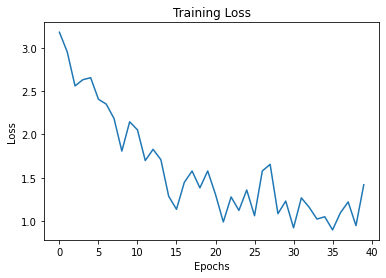

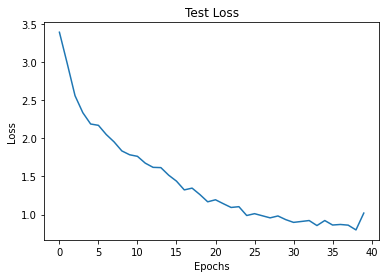

In [13]:
numEpochs = 40
lr_rate = 1e-6

input_size = 18

# b_size = 1000

model = myNeuralNetwork(input_size)
# model = myNeuralNetwork2(input_size)

loss_function = nn.MSELoss() # Change to BCELoss for classification problem

if using_GPU:
  model = model.cuda()

# Check if the Module is on GPU by checking if a parameter is on GPU
print("Model on GPU?:")
print(next(model.parameters()).is_cuda)

# optimizer = torch.optim.SGD(model.parameters(), lr=lr_rate)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=True)
# https://ruder.io/optimizing-gradient-descent/


train_loss_lst = []
test_loss_lst_1 = []
# prevMSELoss:float
def train():
    for m in tqdm(range(numEpochs)):
        model.train()
        for X, y in train_loader:

            X = torch.squeeze(X).cuda()
            y = y.T.cuda()

            optimizer.zero_grad() 
            y_hat = model(X)
            y_log = torch.log(y+1)
            loss = loss_function(y_hat, y_log) #calculate the loss
            loss.backward() #backprop
            optimizer.step() #does the update

        train_loss_lst.append(loss.cpu().data.numpy())

        model.eval()
        
        test_loss_lst = []
        for (n, (X, y)) in enumerate(test_loader):
            X = torch.squeeze(X).cuda()
            y = y.T.cuda()
            y_hat = model(X)
            y_log = torch.log(y+1)
            test_loss = loss_function(y_hat, y_log)
            test_loss_lst.append(test_loss.cpu().data.numpy())
            
        if m % 1 == 0:
            print ("Epoch: {0}, Loss: {1}, ".format(m, loss.cpu().data.numpy()))
            print(f"MSELoss: {test_loss}")
            avgMSELoss = sum(test_loss_lst)/len(test_loss_lst)
            test_loss_lst_1.append(avgMSELoss)
            print(f"Average MSELoss: {avgMSELoss}")

        if m % 5 == 0:
            PATH = "model/model_{0}_{1}.pt".format(d4, m)
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
                }, PATH)
            print(PATH)
            PATH1 = "model_{0}_{1}.pt".format(d4, m)
            pd.DataFrame(train_loss_lst).to_csv("model_loss_graph/train_loss_" + PATH1 +"_1" + '.csv')
            pd.DataFrame(test_loss_lst_1).to_csv("model_loss_graph/test_loss_" + PATH1 +"_1"  + '.csv')
        
train()

plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(train_loss_lst)
plt.show()

plt.title("Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(test_loss_lst_1)
plt.show()

In [14]:
# now = datetime.now()

# d4 = now.strftime("%Y%m%d_%H%M%S")

PATH = "model/model_{0}.pt".format(d4) #change this name to the name of your network

print(PATH)

torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, PATH)

PATH1 = "model_{0}.pt".format(d4)

pd.DataFrame(train_loss_lst).to_csv("model_loss_graph/train_loss_" + PATH1 +"_1" + '.csv')
pd.DataFrame(test_loss_lst_1).to_csv("model_loss_graph/test_loss_" + PATH1 +"_1"  + '.csv')

model/model_20210809_032813.pt


In [12]:
PATH = "model/model_20210809_032813_35.pt"

input_size = 18

# init empty model
model = myNeuralNetwork(input_size)

loss_function = nn.MSELoss() # Change to BCELoss for classification problem

# load checkpoint from saved path
checkpoint = torch.load(PATH)

# load model
model.load_state_dict(checkpoint['model_state_dict'])

if using_GPU:
  model = model.cuda()

model.eval()
test_loss_lst = []
y_e_list = []
y_list = []
for (n, (X, y)) in enumerate(test_loader):
    X = torch.squeeze(X).cuda()
    y = y.T.cuda()
    
    y_hat = model(X)
    y_e = torch.exp(y_hat) - 1

    y_log = torch.log(y+1)

    y_list.append(y.cpu().data.numpy())
    y_e_list.append(y_e.cpu().data.numpy())

    test_loss = loss_function(y_hat, y_log)
    test_loss_lst.append(test_loss.cpu().data.numpy())

print(f"MSELoss: {test_loss}")
avgMSELoss = sum(test_loss_lst)/len(test_loss_lst)
print(f"Average MSELoss: {avgMSELoss}")
# print(y_list)


MSELoss: 0.8158085942268372
Average MSELoss: 0.859916964247207


In [13]:
flatten_y = np.concatenate(y_list).ravel()
flatten_y_e = np.concatenate(y_e_list).ravel()

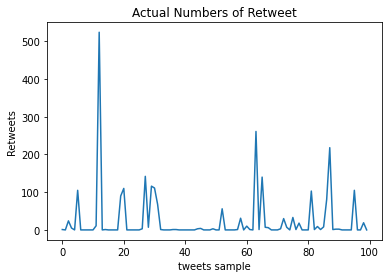

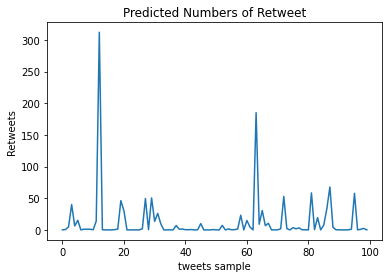

In [14]:
i = np.random.randint(100)

plt.title("Actual Numbers of Retweet")
plt.xlabel("tweets sample")
plt.ylabel("Retweets")
plt.plot(flatten_y[i:i+100], label = "Actual")
plt.show()

plt.title("Predicted Numbers of Retweet")
plt.xlabel("tweets sample")
plt.ylabel("Retweets")
plt.plot(flatten_y_e[i:i+100] , label = "predicted")
plt.show()

In [15]:
df_y = pd.DataFrame(flatten_y)
df_y_e = pd.DataFrame(flatten_y_e).astype(int)
df_y_combined =pd.concat([df_y,df_y_e],axis=1)
df_y_combined.columns = ['Actual', 'Predicted']
print(df_y_combined)

         Actual  Predicted
0          27.0         14
1           0.0          0
2          11.0          2
3           2.0          5
4          47.0         31
...         ...        ...
6027424     0.0          0
6027425     0.0          0
6027426     0.0          0
6027427     0.0          0
6027428     0.0          0

[6027429 rows x 2 columns]


In [16]:
df_y_combined.to_csv("retweets_comparison/actual_predicted_model_20210809_032813_35_2" + '.csv')

In [17]:
mse_loss = (((df_y_e - df_y)**2)**(0.5)).mean(axis=0)
print(mse_loss)

0    30.045418
dtype: float64
